Name: Rahul Govindkumar

In [5]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from IPython import display
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Conv2DTranspose, Dropout, UpSampling2D, BatchNormalization, Activation, Concatenate,MaxPooling2D


In [6]:

## helper funciton for loading the horses data
#make sure the horses data is in the same directory as the notebook
#do not change this function
def load_horses_orig(path, image_size):   
    mask_path = path + 'masks/'
    image_path = path + 'images/'
    images = []
    masks = []
    test_images= []
    test_masks =[]
    for i in range(328):
        
        orig_im = cv2.imread(image_path + 'image-{}.png'.format(i))
        orig_im= cv2.cvtColor(orig_im, cv2.COLOR_RGB2BGR)
        
        low_im = cv2.resize(orig_im, dsize=(image_size, image_size))

        orig_mask = cv2.imread(mask_path + 'mask-{}.png'.format(i))
        low_mask = cv2.resize(orig_mask, dsize=(image_size, image_size))
        low_mask = cv2.cvtColor(low_mask, cv2.COLOR_RGB2GRAY)
        bin_mask = (low_mask > 0) + 0
        
    
        images.append(low_im)
        masks.append(bin_mask)


    xtest = np.reshape(np.array(images[250:]), (-1,image_size*image_size*3))
    ytest = np.reshape(np.array(masks[250:]), (-1, image_size * image_size))
    xdata = np.reshape(np.array(images[:200]), (-1,image_size*image_size*3))
    ydata = np.reshape(np.array(masks[:200]), (-1, image_size * image_size))
    yval =  np.reshape(np.array(masks[200:250]), (-1, image_size * image_size))
    xval = np.reshape(np.array(images[200:250]), (-1,image_size*image_size*3))


    return xdata, xval, xtest, ydata, yval, ytest


In [7]:
#change the path address if put the data somewhere else
path = './horses/'
image_size = 32;
xdata, xval, xtest, ydata, yval, ytest = load_horses_orig(path, image_size)

error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [ ]:
#helper function to drawing horse and its mask
def draw(image, mask):
    fig, (ax1,ax2) = plt.subplots(1,2) 
    ax1.axis('off')
    ax2.axis('off')
    ax1.imshow(np.reshape(image, (image_size,image_size,3)))
    ax2.imshow(np.reshape(mask, (image_size,image_size)), cmap=plt.cm.gray)
    plt.show()

The task is to predict the mask for the horse given the image
Mask is binary image shows the presence of the horse.

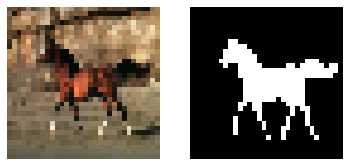

In [ ]:
 draw(xdata[0], ydata[0])

In [ ]:
train_size = xdata.shape[0]
batch_size = 10
train_dataset = (tf.data.Dataset.from_tensor_slices(np.hstack((xdata, ydata)))
                 .shuffle(train_size).batch(batch_size))

The intersection over union (IOU) is a metric for measuring the performance of image segmentation. The perfect segmentation receives IOU of one.

In [ ]:
# Do not change this cell
def iou(ytrue, yprediction):
    yp = yprediction
    yt = ytrue
    yp = yp > 0.5 + 0
    intersect = np.sum(np.minimum(yp, yt),1)
    union = np.sum(np.maximum(yp, yt),1)
    return np.average(intersect / (union+0.0))
        

In [ ]:
assert iou(ydata, ydata) == 1.0

We can use feedforwad MLP or CNN  model for image segmentation. Here the input is the image and the output is the segmentation mask.

In [ ]:
from keras.backend import concatenate
class NeuralNet(tf.keras.Model):
    
    def construct_CNN(self):
        # COMPLETE ME
        activation="relu"
        dropout=0.1
    
   
        input_shape=(image_size, image_size, 3)
        inputs= tf.keras.Input(input_shape)       

        #(ENCODER)
        c1 = Conv2D(32, 3 , activation=activation, padding='same') (inputs)
        c1 = BatchNormalization()(c1)
        c1 = Conv2D(32, 3 , activation=activation, padding='same') (c1)
        c1 = BatchNormalization()(c1)    
        p1 = MaxPooling2D((2, 2)) (c1)
       


        c2 = Conv2D(64, 3, activation=activation, padding='same') (p1)
        c2 = BatchNormalization()(c2)
        c2 = Conv2D(64, 3, activation=activation, padding='same') (c2)
        c2 = BatchNormalization()(c2)
        p2 = MaxPooling2D((2, 2)) (c2)
   


        c3 = Conv2D(128, 3, activation=activation, padding='same') (p2)
        c3 = BatchNormalization()(c3)
        c3 = Conv2D(128, 3, activation=activation, padding='same') (c3)
        c3 = BatchNormalization()(c3)
        p3 = MaxPooling2D((2, 2)) (c3)



        c4 = Conv2D(256, 3, activation=activation,  padding='same') (p3)
        c4 = BatchNormalization()(c4)
        c4 = Conv2D(256, 3, activation=activation,  padding='same') (c4)
        c4 = BatchNormalization()(c4)       
        p4 = MaxPooling2D(pool_size=(2, 2)) (c4)


        c5 = Conv2D(512, 3, activation=activation, padding='same') (p4)
        c5 = BatchNormalization()(c5)
        c5 = Conv2D(512, 3, activation=activation, padding='same') (c5)
        c5 = BatchNormalization()(c5)
        



        #(DECODER)
        
        u6 = Conv2DTranspose(256, 3, strides=2, padding='same') (c5)
        u6 = concatenate([u6, c4])
        c6 = Conv2D(256, 3, activation=activation,  padding='same') (u6)
        c6 = BatchNormalization()(c6)
        c6 = Conv2D(256, 3, activation=activation,  padding='same') (c6)
        c6 = BatchNormalization()(c6)
        
        
        u7 = Conv2DTranspose(128, 3, strides=2, padding='same') (c6)
        u7 = concatenate([u7, c3])
        c7 = Conv2D(128, 3, activation=activation, padding='same') (u7)
        c7 = BatchNormalization()(c7)
        c7 = Conv2D(128, 3, activation=activation, padding='same') (c7)
        c7 = BatchNormalization()(c7)
       
        
               
        u8 = Conv2DTranspose(64, 3, strides=2, padding='same') (c7)
        u8 = concatenate([u8, c2])
        c8 = Conv2D(64, 3, activation=activation, padding='same') (u8)
        c8 = BatchNormalization()(c8)
        c8 = Conv2D(64, 3, activation=activation, padding='same') (c8)
        c8 = BatchNormalization()(c8)
     


        u9 = Conv2DTranspose(32, 3, strides=2, padding='same') (c8)
        u9 = concatenate([u9, c1],axis=3)
        c9 = Conv2D(32, 3, activation=activation,padding='same') (u9)
        c9 = BatchNormalization()(c9)
        c9 = Conv2D(32, 3, activation=activation,padding='same') (c9)
        c9 = BatchNormalization()(c9)
        
      
        output = Conv2D(1, 1, padding='same') (c9)
        output = Flatten () (output)

        model = tf.keras.Model(inputs, output)
        
        self.model = model


    
    def construct_MLP(self):
         self.model = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(image_size, image_size, 3), dtype='float32'),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(500, activation='relu'),
                tf.keras.layers.Dropout(.2, input_shape=(500,)),
                tf.keras.layers.Dense(20, activation='relu'),
                tf.keras.layers.Dense(image_size*image_size)
            ]
        )
    
    
    def __init__(self, network_type ):
        super(NeuralNet, self).__init__()
        #DOCUMENT ME
        #
        """
        Optimizers are used to minimize an error function (loss function) or to maximize the efficiency of production
        
        """
        self.optimizer = tf.keras.optimizers.SGD(0.0000001)
        #What are the other available optimizers
        #Test your code with different optimizers - Please refer the below Code with Header - Testing With Different Optimizer 
        """
        
        Available optimizers
            - SGD      [In stochastic gradient descent, instead of taking the whole dataset for each iteration, it randomly selects the batches of data.]
            - RMSprop  [RMS prop can also be considered an advancement in AdaGrad optimizer as it reduces the monotonically decreasing learning rate]
            - Adam     [daptive moment estimation which is extension of stochastic gradient descent to update network weights during training]
            - Adadelta [It is more robust version of AdaGrad optimizer. AdaDelta uses two state variables to store the leaky average of the second moment gradient and a leaky average of the second moment of change of parameters in the model. ]
            - Adagrad  [The adaptive gradient descent algorithm is different from other gradient descent algorithms as it uses different learning rates for each iteration. The change in learning rate depends upon the difference in the parameters during training]
            - Adamax   [AdaMax is an extension to the Adam version of gradient descent that generalizes the approach to the infinite norm (max) and may result in a more effective optimization on some problems]
            - Nadam
            - Ftrl
        Except from SGD, others are Adaptive optimizers

        On testing the code with the following optimizers for 100 epochs, below are the observation after 50 Epochs and the Final IOU

        ADAM
        Epoch 50, Loss: 3.52e+03, IOU - Train: 0.978 Valid: 0.762 Test: 0.793
        IOU: 0.793213448518527

        SGD: Updates the weights after seeing each data points
        Epoch 50, Loss: 5.56e+04, IOU - Train: 0.66 Valid: 0.583 Test: 0.675
        IOU: 0.7186441827007882

        Adagrad: Adaptive Lea
        Epoch 50, Loss: 4.46e+04, IOU - Train: 0.704 Valid: 0.63 Test: 0.687
        IOU: 0.7200430199134298

        Adadelta
        Epoch 50, Loss: 1.14e+05, IOU - Train: 0.502 Valid: 0.459 Test: 0.506
        IOU: 0.5237069707087039

        Adamax
        Epoch 50, Loss: 1.06e+04, IOU - Train: 0.933 Valid: 0.733 Test: 0.773
        IOU: 0.7728205776406226

        RMSprop
        Epoch 50, Loss: 7.09e+03, IOU - Train: 0.928 Valid: 0.751 Test: 0.814
        IOU: 0.8139378503341943 

        Adam, RMSprop and Adamax converged quicker than other optimizer 

        """
        

        
        
        if network_type == 'MLP':
            self.construct_MLP();
        else:
            self.construct_CNN();
        

    #DOCUMENT ME
    #
    """
    The forward pass refers to calculation process, values of the output layers from the inputs data.

    Here Sigmoid is used which is being called to predict values of ytest_pred, yval_pred, ydata_pred
    so that we can easily interpret the output as probabilities since it has restricted output between 0 and 1. 
    One of the main disadvantages for using sigmoid function on hidden layers is that the gradient is very close to 
    zero over a large portion of its domain which makes it slow and harder for the learning algorithm to learn.

    """
    def forward(self, x, predict=True):
        if predict:
            return tf.nn.sigmoid(self.model(x))
        return self.model(x)
  
    def get_loss(self, x, yt):
        x = tf.reshape(x, (-1, image_size, image_size, 3))
        yt = tf.reshape(yt, (-1, image_size * image_size))
        ylogits = self.forward(x, predict=False);
        
        #DOCUMENT ME
        #What is the difference of sigmoid_cross_entropy_with_logits and sigmoid_cross_entropy?
        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=ylogits, labels=yt);

        """
        The cross-entropy describe how likely a model is and the error function of each data point. It can also be used to describe a predicted outcome compare to the true outcome
      sigmoid_cross_entropy_with_logits is used in multilabel classification. 
      It measures the probability error in tasks with two outcomes in which each outcome is independent and need not have a fully certain label.
      In sigmoid_cross_entropy weights acts as a coefficient for the loss.
      Weighted loss Tensor of the same type as logits. If reduction is NONE, this has the same shape as logits; otherwise, it is scalar
       
        """
        
        
        return tf.reduce_sum(cross_ent)
  
   
    def train_step(self, xbatch,ybatch):
        
        #DOCUMENT ME
        #
        """
        Gradient tape is a mathematical tool for automatic differentiation (autodiff), which is the core functionality of TensorFlow. 
        It give you direct access to the individual gradients that are in the layer
        """
        with tf.GradientTape() as tape:
            loss = self.get_loss(xbatch, ybatch)
        #DOCUMENT ME
        #

        """
        Computes the gradient using operations recorded in context of this tape.
        Unless you set persistent=True a GradientTape can only be used to
        compute one set of gradients 
        It returns a list or nested structure of Tensors,
        one for each element in sources. Returned structure is the same as
        the structure of sources.

        """
        gradients = tape.gradient(loss, model.trainable_variables)
        
        #DOCUMENT ME
        #
        """
         apply_gradients() is useful if you need to process aggregated gradients.This method sums gradients from all replicas
        """
        self.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return tf.reduce_sum(loss)

    def predict(self, x):
        y = self.forward(x, predict=True)
        return y.numpy() #tf.reshape(y, (-1, image_size, image_size)).numpy()


In [ ]:
model = NeuralNet('CNN')
#model = NeuralNet('MLP')
train_iou = []
val_iou = []
test_iou = []
epoch = 1;
best_val_iou = -1;
best_test_iou = -1

In [ ]:
#Adopt similar training loop for other problems

max_epoch = 5000

while epoch < max_epoch:
    loss = 0.0
    for batch in train_dataset:
        xbatch = batch[:,:image_size*image_size*3]
        ybatch = batch[:,image_size*image_size*3:]
        xbatch = tf.cast(xbatch, tf.float32);
        ybatch = tf.cast(ybatch, tf.float32);
        loss += model.train_step(xbatch, ybatch);
  
    ydata_pred = model.predict(tf.reshape(xdata, (-1, image_size, image_size, 3 )));
    yval_pred = model.predict(tf.reshape(xval, (-1, image_size, image_size, 3 )));
    ytest_pred = model.predict(tf.reshape(xtest, (-1, image_size, image_size, 3 )));
    
    train_iou.append(iou(ydata,ydata_pred))
    val_iou.append(iou(yval,yval_pred))
    test_iou.append(iou(ytest,ytest_pred))

    if val_iou[-1] > best_val_iou:
        best_test_iou = test_iou[-1]
        best_val_iou = val_iou[-1]
        model.save_weights("best_model");
    
  
    print("Epoch {}, Loss: {:0.3}, IOU - Train: {:0.3} Valid: {:0.3} Test: {:0.3}".format( epoch, loss.numpy(), train_iou[-1], val_iou[-1], best_test_iou))
  

 
    epoch += 1


Epoch 1, Loss: 3.2e+05, IOU - Train: 0.258 Valid: 0.249 Test: 0.278
Epoch 2, Loss: 1.26e+05, IOU - Train: 0.346 Valid: 0.328 Test: 0.364
Epoch 3, Loss: 1.18e+05, IOU - Train: 0.252 Valid: 0.228 Test: 0.364
Epoch 4, Loss: 1.12e+05, IOU - Train: 0.325 Valid: 0.296 Test: 0.364
Epoch 5, Loss: 1.07e+05, IOU - Train: 0.391 Valid: 0.379 Test: 0.407
Epoch 6, Loss: 1.04e+05, IOU - Train: 0.362 Valid: 0.326 Test: 0.407
Epoch 7, Loss: 9.96e+04, IOU - Train: 0.387 Valid: 0.35 Test: 0.407
Epoch 8, Loss: 1.01e+05, IOU - Train: 0.375 Valid: 0.333 Test: 0.407
Epoch 9, Loss: 9.66e+04, IOU - Train: 0.343 Valid: 0.3 Test: 0.407
Epoch 10, Loss: 9.56e+04, IOU - Train: 0.303 Valid: 0.259 Test: 0.407
Epoch 11, Loss: 9.45e+04, IOU - Train: 0.417 Valid: 0.374 Test: 0.407
Epoch 12, Loss: 9.06e+04, IOU - Train: 0.459 Valid: 0.432 Test: 0.47
Epoch 13, Loss: 9.11e+04, IOU - Train: 0.414 Valid: 0.366 Test: 0.47
Epoch 14, Loss: 9.17e+04, IOU - Train: 0.443 Valid: 0.401 Test: 0.47
Epoch 15, Loss: 8.75e+04, IOU - Trai

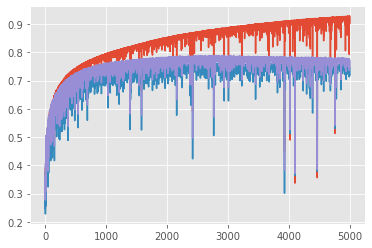

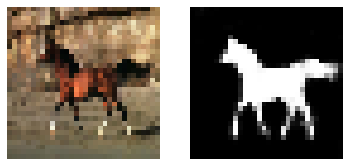

In [ ]:
fig, ax = plt.subplots(1,1)
pd.Series(train_iou).plot(ax=ax)
pd.Series(val_iou).plot(ax=ax)
pd.Series(test_iou).plot(ax=ax)
fig.canvas.draw()

draw(xdata[0], ydata_pred[0])

In [ ]:
model.load_weights("best_model")
ypred = model.predict(tf.reshape(xtest, (-1, image_size, image_size, 3 )));

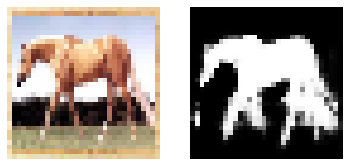

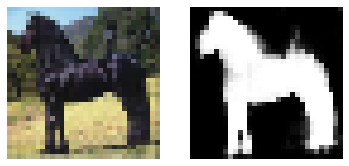

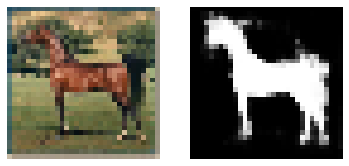

In [ ]:
draw(xtest[10], ypred[10])
draw(xtest[25], ypred[25])
draw(xtest[20], ypred[20])

In [ ]:


iou(ytest, ypred)

0.7865498816772766

# Testing With Different Optimizer

# Optimizer := Adam

Testing with ADAM for 100 Epoch with Learning rate := 0.01

In [ ]:
from keras.backend import concatenate
class NeuralNet(tf.keras.Model):
    
    def construct_CNN(self):
        # COMPLETE ME
        activation="relu"
        dropout=0.1
        
    
   
        input_shape=(image_size, image_size, 3)
        inputs= tf.keras.Input(input_shape)       

        #(ENCODER)
        c1 = Conv2D(32, 3 , activation=activation, padding='same') (inputs)
        c1 = BatchNormalization()(c1)
        c1 = Conv2D(32, 3 , activation=activation, padding='same') (c1)
        c1 = BatchNormalization()(c1)    
        p1 = MaxPooling2D((2, 2)) (c1)
       


        c2 = Conv2D(64, 3, activation=activation, padding='same') (p1)
        c2 = BatchNormalization()(c2)
        c2 = Conv2D(64, 3, activation=activation, padding='same') (c2)
        c2 = BatchNormalization()(c2)
        p2 = MaxPooling2D((2, 2)) (c2)
   


        c3 = Conv2D(128, 3, activation=activation, padding='same') (p2)
        c3 = BatchNormalization()(c3)
        c3 = Conv2D(128, 3, activation=activation, padding='same') (c3)
        c3 = BatchNormalization()(c3)
        p3 = MaxPooling2D((2, 2)) (c3)



        c4 = Conv2D(256, 3, activation=activation,  padding='same') (p3)
        c4 = BatchNormalization()(c4)
        c4 = Conv2D(256, 3, activation=activation,  padding='same') (c4)
        c4 = BatchNormalization()(c4)       
        p4 = MaxPooling2D(pool_size=(2, 2)) (c4)


        c5 = Conv2D(512, 3, activation=activation, padding='same') (p4)
        c5 = BatchNormalization()(c5)
        c5 = Conv2D(512, 3, activation=activation, padding='same') (c5)
        c5 = BatchNormalization()(c5)
        



        #(DECODER)
        
        u6 = Conv2DTranspose(256, 3, strides=2, padding='same') (c5)
        u6 = concatenate([u6, c4])
        c6 = Conv2D(256, 3, activation=activation,  padding='same') (u6)
        c6 = BatchNormalization()(c6)
        c6 = Conv2D(256, 3, activation=activation,  padding='same') (c6)
        c6 = BatchNormalization()(c6)
        
        
        u7 = Conv2DTranspose(128, 3, strides=2, padding='same') (c6)
        u7 = concatenate([u7, c3])
        c7 = Conv2D(128, 3, activation=activation, padding='same') (u7)
        c7 = BatchNormalization()(c7)
        c7 = Conv2D(128, 3, activation=activation, padding='same') (c7)
        c7 = BatchNormalization()(c7)
       
        
               
        u8 = Conv2DTranspose(64, 3, strides=2, padding='same') (c7)
        u8 = concatenate([u8, c2])
        c8 = Conv2D(64, 3, activation=activation, padding='same') (u8)
        c8 = BatchNormalization()(c8)
        c8 = Conv2D(64, 3, activation=activation, padding='same') (c8)
        c8 = BatchNormalization()(c8)
     


        u9 = Conv2DTranspose(32, 3, strides=2, padding='same') (c8)
        u9 = concatenate([u9, c1],axis=3)
        c9 = Conv2D(32, 3, activation=activation,padding='same') (u9)
        c9 = BatchNormalization()(c9)
        c9 = Conv2D(32, 3, activation=activation,padding='same') (c9)
        c9 = BatchNormalization()(c9)
        
      
        output = Conv2D(1, 1, padding='same') (c9)
        output = Flatten () (output)

        model = tf.keras.Model(inputs, output)
        
        self.model = model


    
    def construct_MLP(self):
         self.model = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(image_size, image_size, 3), dtype='float32'),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(500, activation='relu'),
                tf.keras.layers.Dropout(.2, input_shape=(500,)),
                tf.keras.layers.Dense(20, activation='relu'),
                tf.keras.layers.Dense(image_size*image_size)
            ]
        )
    
    
    def __init__(self, network_type ):
        super(NeuralNet, self).__init__()

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,
                                                  beta_1=0.9,
                                                  beta_2=0.999,
                                                  epsilon=1e-07)

        
        
        if network_type == 'MLP':
            self.construct_MLP();
        else:
            self.construct_CNN();
        

    def forward(self, x, predict=True):
        if predict:
            return tf.nn.sigmoid(self.model(x))
        return self.model(x)
  
    def get_loss(self, x, yt):
        x = tf.reshape(x, (-1, image_size, image_size, 3))
        yt = tf.reshape(yt, (-1, image_size * image_size))
        ylogits = self.forward(x, predict=False);
        
     
        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=ylogits, labels=yt);
        
        
        return tf.reduce_sum(cross_ent)
  
   
    def train_step(self, xbatch,ybatch):
        
    
        with tf.GradientTape() as tape:
            loss = self.get_loss(xbatch, ybatch)

        gradients = tape.gradient(loss, model.trainable_variables)
        

        self.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return tf.reduce_sum(loss)

    def predict(self, x):
        y = self.forward(x, predict=True)
        return y.numpy() #tf.reshape(y, (-1, image_size, image_size)).numpy()


In [ ]:
model = NeuralNet('CNN')
#model = NeuralNet('MLP')
train_iou = []
val_iou = []
test_iou = []
epoch = 1;
best_val_iou = -1;
best_test_iou = -1

In [ ]:
#Adopt similar training loop for other problems

max_epoch = 100

while epoch < max_epoch:
    loss = 0.0
    for batch in train_dataset:
        xbatch = batch[:,:image_size*image_size*3]
        ybatch = batch[:,image_size*image_size*3:]
        xbatch = tf.cast(xbatch, tf.float32);
        ybatch = tf.cast(ybatch, tf.float32);
        loss += model.train_step(xbatch, ybatch);
  
    ydata_pred = model.predict(tf.reshape(xdata, (-1, image_size, image_size, 3 )));
    yval_pred = model.predict(tf.reshape(xval, (-1, image_size, image_size, 3 )));
    ytest_pred = model.predict(tf.reshape(xtest, (-1, image_size, image_size, 3 )));
    
    train_iou.append(iou(ydata,ydata_pred))
    val_iou.append(iou(yval,yval_pred))
    test_iou.append(iou(ytest,ytest_pred))

    if val_iou[-1] > best_val_iou:
        best_test_iou = test_iou[-1]
        best_val_iou = val_iou[-1]
        model.save_weights("best_model");
    
  
    print("Epoch {}, Loss: {:0.3}, IOU - Train: {:0.3} Valid: {:0.3} Test: {:0.3}".format( epoch, loss.numpy(), train_iou[-1], val_iou[-1], best_test_iou))
  

 
    epoch += 1


Epoch 1, Loss: 2.76e+05, IOU - Train: 0.295 Valid: 0.266 Test: 0.322
Epoch 2, Loss: 9.39e+04, IOU - Train: 0.523 Valid: 0.478 Test: 0.536
Epoch 3, Loss: 7.27e+04, IOU - Train: 0.599 Valid: 0.534 Test: 0.61
Epoch 4, Loss: 6.03e+04, IOU - Train: 0.601 Valid: 0.522 Test: 0.61
Epoch 5, Loss: 5.6e+04, IOU - Train: 0.617 Valid: 0.546 Test: 0.611
Epoch 6, Loss: 5.26e+04, IOU - Train: 0.674 Valid: 0.603 Test: 0.663
Epoch 7, Loss: 5.07e+04, IOU - Train: 0.681 Valid: 0.627 Test: 0.684
Epoch 8, Loss: 4.81e+04, IOU - Train: 0.677 Valid: 0.611 Test: 0.684
Epoch 9, Loss: 4.48e+04, IOU - Train: 0.697 Valid: 0.671 Test: 0.712
Epoch 10, Loss: 4.34e+04, IOU - Train: 0.731 Valid: 0.658 Test: 0.712
Epoch 11, Loss: 3.97e+04, IOU - Train: 0.741 Valid: 0.687 Test: 0.736
Epoch 12, Loss: 3.8e+04, IOU - Train: 0.765 Valid: 0.702 Test: 0.748
Epoch 13, Loss: 3.56e+04, IOU - Train: 0.762 Valid: 0.705 Test: 0.744
Epoch 14, Loss: 3.3e+04, IOU - Train: 0.786 Valid: 0.724 Test: 0.767
Epoch 15, Loss: 3.07e+04, IOU - Tr

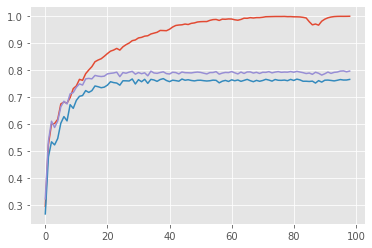

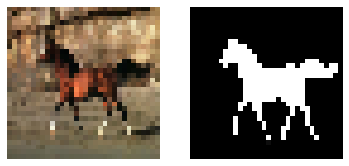

In [ ]:
fig, ax = plt.subplots(1,1)
pd.Series(train_iou).plot(ax=ax)
pd.Series(val_iou).plot(ax=ax)
pd.Series(test_iou).plot(ax=ax)
fig.canvas.draw()

draw(xdata[0], ydata_pred[0])

In [ ]:
model.load_weights("best_model")
ypred = model.predict(tf.reshape(xtest, (-1, image_size, image_size, 3 )));

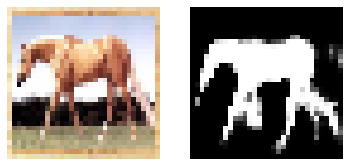

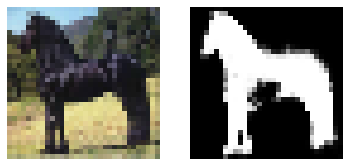

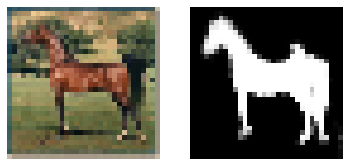

In [ ]:
draw(xtest[10], ypred[10])
draw(xtest[25], ypred[25])
draw(xtest[20], ypred[20])

In [ ]:
#IOU

iou(ytest, ypred)

0.793213448518527

# Optimizer := SGD

Testing with SGD for 100 Epoch with Learning rate as := 0.000001

In [ ]:
from keras.backend import concatenate
class NeuralNet(tf.keras.Model):
    
    def construct_CNN(self):
        # COMPLETE ME
        activation="relu"
        dropout=0.1
        
    
   
        input_shape=(image_size, image_size, 3)
        inputs= tf.keras.Input(input_shape)       

        #(ENCODER)
        c1 = Conv2D(32, 3 , activation=activation, padding='same') (inputs)
        c1 = BatchNormalization()(c1)
        c1 = Conv2D(32, 3 , activation=activation, padding='same') (c1)
        c1 = BatchNormalization()(c1)    
        p1 = MaxPooling2D((2, 2)) (c1)
       


        c2 = Conv2D(64, 3, activation=activation, padding='same') (p1)
        c2 = BatchNormalization()(c2)
        c2 = Conv2D(64, 3, activation=activation, padding='same') (c2)
        c2 = BatchNormalization()(c2)
        p2 = MaxPooling2D((2, 2)) (c2)
   


        c3 = Conv2D(128, 3, activation=activation, padding='same') (p2)
        c3 = BatchNormalization()(c3)
        c3 = Conv2D(128, 3, activation=activation, padding='same') (c3)
        c3 = BatchNormalization()(c3)
        p3 = MaxPooling2D((2, 2)) (c3)



        c4 = Conv2D(256, 3, activation=activation,  padding='same') (p3)
        c4 = BatchNormalization()(c4)
        c4 = Conv2D(256, 3, activation=activation,  padding='same') (c4)
        c4 = BatchNormalization()(c4)       
        p4 = MaxPooling2D(pool_size=(2, 2)) (c4)


        c5 = Conv2D(512, 3, activation=activation, padding='same') (p4)
        c5 = BatchNormalization()(c5)
        c5 = Conv2D(512, 3, activation=activation, padding='same') (c5)
        c5 = BatchNormalization()(c5)
        



        #(DECODER)
        
        u6 = Conv2DTranspose(256, 3, strides=2, padding='same') (c5)
        u6 = concatenate([u6, c4])
        c6 = Conv2D(256, 3, activation=activation,  padding='same') (u6)
        c6 = BatchNormalization()(c6)
        c6 = Conv2D(256, 3, activation=activation,  padding='same') (c6)
        c6 = BatchNormalization()(c6)
        
        
        u7 = Conv2DTranspose(128, 3, strides=2, padding='same') (c6)
        u7 = concatenate([u7, c3])
        c7 = Conv2D(128, 3, activation=activation, padding='same') (u7)
        c7 = BatchNormalization()(c7)
        c7 = Conv2D(128, 3, activation=activation, padding='same') (c7)
        c7 = BatchNormalization()(c7)
       
        
               
        u8 = Conv2DTranspose(64, 3, strides=2, padding='same') (c7)
        u8 = concatenate([u8, c2])
        c8 = Conv2D(64, 3, activation=activation, padding='same') (u8)
        c8 = BatchNormalization()(c8)
        c8 = Conv2D(64, 3, activation=activation, padding='same') (c8)
        c8 = BatchNormalization()(c8)
     


        u9 = Conv2DTranspose(32, 3, strides=2, padding='same') (c8)
        u9 = concatenate([u9, c1],axis=3)
        c9 = Conv2D(32, 3, activation=activation,padding='same') (u9)
        c9 = BatchNormalization()(c9)
        c9 = Conv2D(32, 3, activation=activation,padding='same') (c9)
        c9 = BatchNormalization()(c9)
        
      
        output = Conv2D(1, 1, padding='same') (c9)
        output = Flatten () (output)

        model = tf.keras.Model(inputs, output)
        
        self.model = model


    
    def construct_MLP(self):
         self.model = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(image_size, image_size, 3), dtype='float32'),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(500, activation='relu'),
                tf.keras.layers.Dropout(.2, input_shape=(500,)),
                tf.keras.layers.Dense(20, activation='relu'),
                tf.keras.layers.Dense(image_size*image_size)
            ]
        )
    
    
    def __init__(self, network_type ):
        super(NeuralNet, self).__init__()

        self.optimizer = tf.keras.optimizers.SGD(learning_rate=0.000001)

        
        
        if network_type == 'MLP':
            self.construct_MLP();
        else:
            self.construct_CNN();
        

    def forward(self, x, predict=True):
        if predict:
            return tf.nn.sigmoid(self.model(x))
        return self.model(x)
  
    def get_loss(self, x, yt):
        x = tf.reshape(x, (-1, image_size, image_size, 3))
        yt = tf.reshape(yt, (-1, image_size * image_size))
        ylogits = self.forward(x, predict=False);

        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=ylogits, labels=yt);
        
        
        return tf.reduce_sum(cross_ent)
  
   
    def train_step(self, xbatch,ybatch):
 
        with tf.GradientTape() as tape:
            loss = self.get_loss(xbatch, ybatch)
        
        gradients = tape.gradient(loss, model.trainable_variables)
        
        self.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return tf.reduce_sum(loss)

    def predict(self, x):
        y = self.forward(x, predict=True)
        return y.numpy() #tf.reshape(y, (-1, image_size, image_size)).numpy()


In [ ]:
model = NeuralNet('CNN')
#model = NeuralNet('MLP')
train_iou = []
val_iou = []
test_iou = []
epoch = 1;
best_val_iou = -1;
best_test_iou = -1

In [ ]:
#Adopt similar training loop for other problems

max_epoch = 100

while epoch < max_epoch:
    loss = 0.0
    for batch in train_dataset:
        xbatch = batch[:,:image_size*image_size*3]
        ybatch = batch[:,image_size*image_size*3:]
        xbatch = tf.cast(xbatch, tf.float32);
        ybatch = tf.cast(ybatch, tf.float32);
        loss += model.train_step(xbatch, ybatch);
  
    ydata_pred = model.predict(tf.reshape(xdata, (-1, image_size, image_size, 3 )));
    yval_pred = model.predict(tf.reshape(xval, (-1, image_size, image_size, 3 )));
    ytest_pred = model.predict(tf.reshape(xtest, (-1, image_size, image_size, 3 )));
    
    train_iou.append(iou(ydata,ydata_pred))
    val_iou.append(iou(yval,yval_pred))
    test_iou.append(iou(ytest,ytest_pred))

    if val_iou[-1] > best_val_iou:
        best_test_iou = test_iou[-1]
        best_val_iou = val_iou[-1]
        model.save_weights("best_model");
    
  
    print("Epoch {}, Loss: {:0.3}, IOU - Train: {:0.3} Valid: {:0.3} Test: {:0.3}".format( epoch, loss.numpy(), train_iou[-1], val_iou[-1], best_test_iou))
  

 
    epoch += 1


Epoch 1, Loss: 3.51e+05, IOU - Train: 0.0416 Valid: 0.0378 Test: 0.0531
Epoch 2, Loss: 1.11e+05, IOU - Train: 0.0632 Valid: 0.0529 Test: 0.0809
Epoch 3, Loss: 1.05e+05, IOU - Train: 0.123 Valid: 0.104 Test: 0.148
Epoch 4, Loss: 9.93e+04, IOU - Train: 0.218 Valid: 0.18 Test: 0.247
Epoch 5, Loss: 9.65e+04, IOU - Train: 0.445 Valid: 0.396 Test: 0.473
Epoch 6, Loss: 9.53e+04, IOU - Train: 0.19 Valid: 0.154 Test: 0.473
Epoch 7, Loss: 9.31e+04, IOU - Train: 0.464 Valid: 0.42 Test: 0.492
Epoch 8, Loss: 9.04e+04, IOU - Train: 0.36 Valid: 0.3 Test: 0.492
Epoch 9, Loss: 9.12e+04, IOU - Train: 0.378 Valid: 0.319 Test: 0.492
Epoch 10, Loss: 8.64e+04, IOU - Train: 0.385 Valid: 0.32 Test: 0.492
Epoch 11, Loss: 8.75e+04, IOU - Train: 0.46 Valid: 0.455 Test: 0.499
Epoch 12, Loss: 8.56e+04, IOU - Train: 0.364 Valid: 0.301 Test: 0.499
Epoch 13, Loss: 8.36e+04, IOU - Train: 0.529 Valid: 0.476 Test: 0.554
Epoch 14, Loss: 8.18e+04, IOU - Train: 0.483 Valid: 0.411 Test: 0.554
Epoch 15, Loss: 7.98e+04, IOU -

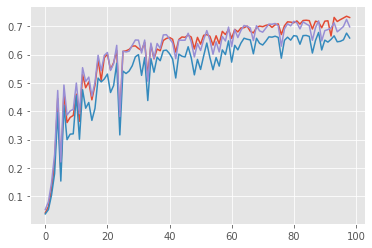

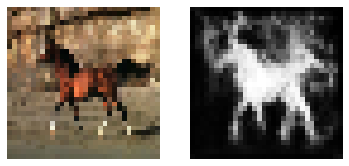

In [ ]:
fig, ax = plt.subplots(1,1)
pd.Series(train_iou).plot(ax=ax)
pd.Series(val_iou).plot(ax=ax)
pd.Series(test_iou).plot(ax=ax)
fig.canvas.draw()

draw(xdata[0], ydata_pred[0])

In [ ]:
model.load_weights("best_model")
ypred = model.predict(tf.reshape(xtest, (-1, image_size, image_size, 3 )));

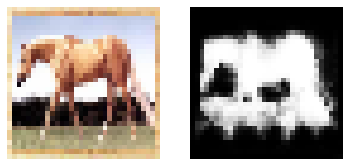

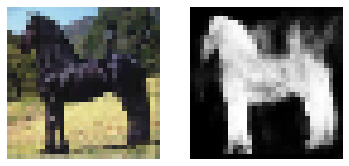

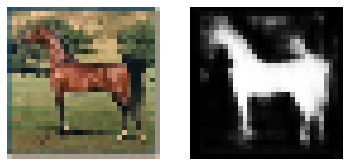

In [ ]:
draw(xtest[10], ypred[10])
draw(xtest[25], ypred[25])
draw(xtest[20], ypred[20])

In [ ]:
#IOU

iou(ytest, ypred)

0.7186441827007882

# Optimizer := Adagrad

Testing with Adagrad for 100 Epoch with Learning rate as := 0.01

In [ ]:
from keras.backend import concatenate
class NeuralNet(tf.keras.Model):
    
    def construct_CNN(self):
        # COMPLETE ME
        activation="relu"
        dropout=0.1
        
    
   
        input_shape=(image_size, image_size, 3)
        inputs= tf.keras.Input(input_shape)       

        #(ENCODER)
        c1 = Conv2D(32, 3 , activation=activation, padding='same') (inputs)
        c1 = BatchNormalization()(c1)
        c1 = Conv2D(32, 3 , activation=activation, padding='same') (c1)
        c1 = BatchNormalization()(c1)    
        p1 = MaxPooling2D((2, 2)) (c1)
       


        c2 = Conv2D(64, 3, activation=activation, padding='same') (p1)
        c2 = BatchNormalization()(c2)
        c2 = Conv2D(64, 3, activation=activation, padding='same') (c2)
        c2 = BatchNormalization()(c2)
        p2 = MaxPooling2D((2, 2)) (c2)
   


        c3 = Conv2D(128, 3, activation=activation, padding='same') (p2)
        c3 = BatchNormalization()(c3)
        c3 = Conv2D(128, 3, activation=activation, padding='same') (c3)
        c3 = BatchNormalization()(c3)
        p3 = MaxPooling2D((2, 2)) (c3)



        c4 = Conv2D(256, 3, activation=activation,  padding='same') (p3)
        c4 = BatchNormalization()(c4)
        c4 = Conv2D(256, 3, activation=activation,  padding='same') (c4)
        c4 = BatchNormalization()(c4)       
        p4 = MaxPooling2D(pool_size=(2, 2)) (c4)


        c5 = Conv2D(512, 3, activation=activation, padding='same') (p4)
        c5 = BatchNormalization()(c5)
        c5 = Conv2D(512, 3, activation=activation, padding='same') (c5)
        c5 = BatchNormalization()(c5)
        



        #(DECODER)
        
        u6 = Conv2DTranspose(256, 3, strides=2, padding='same') (c5)
        u6 = concatenate([u6, c4])
        c6 = Conv2D(256, 3, activation=activation,  padding='same') (u6)
        c6 = BatchNormalization()(c6)
        c6 = Conv2D(256, 3, activation=activation,  padding='same') (c6)
        c6 = BatchNormalization()(c6)
        
        
        u7 = Conv2DTranspose(128, 3, strides=2, padding='same') (c6)
        u7 = concatenate([u7, c3])
        c7 = Conv2D(128, 3, activation=activation, padding='same') (u7)
        c7 = BatchNormalization()(c7)
        c7 = Conv2D(128, 3, activation=activation, padding='same') (c7)
        c7 = BatchNormalization()(c7)
       
        
               
        u8 = Conv2DTranspose(64, 3, strides=2, padding='same') (c7)
        u8 = concatenate([u8, c2])
        c8 = Conv2D(64, 3, activation=activation, padding='same') (u8)
        c8 = BatchNormalization()(c8)
        c8 = Conv2D(64, 3, activation=activation, padding='same') (c8)
        c8 = BatchNormalization()(c8)
     


        u9 = Conv2DTranspose(32, 3, strides=2, padding='same') (c8)
        u9 = concatenate([u9, c1],axis=3)
        c9 = Conv2D(32, 3, activation=activation,padding='same') (u9)
        c9 = BatchNormalization()(c9)
        c9 = Conv2D(32, 3, activation=activation,padding='same') (c9)
        c9 = BatchNormalization()(c9)
        
      
        output = Conv2D(1, 1, padding='same') (c9)
        output = Flatten () (output)

        model = tf.keras.Model(inputs, output)
        
        self.model = model


    
    def construct_MLP(self):
         self.model = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(image_size, image_size, 3), dtype='float32'),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(500, activation='relu'),
                tf.keras.layers.Dropout(.2, input_shape=(500,)),
                tf.keras.layers.Dense(20, activation='relu'),
                tf.keras.layers.Dense(image_size*image_size)
            ]
        )
    
    
    def __init__(self, network_type ):
        super(NeuralNet, self).__init__()

        self.optimizer = tf.keras.optimizers.Adagrad(0.01, epsilon=1e-06)

        
        
        if network_type == 'MLP':
            self.construct_MLP();
        else:
            self.construct_CNN();
        

    def forward(self, x, predict=True):
        if predict:
            return tf.nn.sigmoid(self.model(x))
        return self.model(x)
  
    def get_loss(self, x, yt):
        x = tf.reshape(x, (-1, image_size, image_size, 3))
        yt = tf.reshape(yt, (-1, image_size * image_size))
        ylogits = self.forward(x, predict=False);

        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=ylogits, labels=yt);
        
        
        return tf.reduce_sum(cross_ent)
  
   
    def train_step(self, xbatch,ybatch):
 
        with tf.GradientTape() as tape:
            loss = self.get_loss(xbatch, ybatch)
        
        gradients = tape.gradient(loss, model.trainable_variables)
        
        self.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return tf.reduce_sum(loss)

    def predict(self, x):
        y = self.forward(x, predict=True)
        return y.numpy() #tf.reshape(y, (-1, image_size, image_size)).numpy()


In [ ]:
model = NeuralNet('CNN')
#model = NeuralNet('MLP')
train_iou = []
val_iou = []
test_iou = []
epoch = 1;
best_val_iou = -1;
best_test_iou = -1

In [ ]:
#Adopt similar training loop for other problems

max_epoch = 100

while epoch < max_epoch:
    loss = 0.0
    for batch in train_dataset:
        xbatch = batch[:,:image_size*image_size*3]
        ybatch = batch[:,image_size*image_size*3:]
        xbatch = tf.cast(xbatch, tf.float32);
        ybatch = tf.cast(ybatch, tf.float32);
        loss += model.train_step(xbatch, ybatch);
  
    ydata_pred = model.predict(tf.reshape(xdata, (-1, image_size, image_size, 3 )));
    yval_pred = model.predict(tf.reshape(xval, (-1, image_size, image_size, 3 )));
    ytest_pred = model.predict(tf.reshape(xtest, (-1, image_size, image_size, 3 )));
    
    train_iou.append(iou(ydata,ydata_pred))
    val_iou.append(iou(yval,yval_pred))
    test_iou.append(iou(ytest,ytest_pred))

    if val_iou[-1] > best_val_iou:
        best_test_iou = test_iou[-1]
        best_val_iou = val_iou[-1]
        model.save_weights("best_model");
    
  
    print("Epoch {}, Loss: {:0.3}, IOU - Train: {:0.3} Valid: {:0.3} Test: {:0.3}".format( epoch, loss.numpy(), train_iou[-1], val_iou[-1], best_test_iou))
  

 
    epoch += 1


Epoch 1, Loss: 3.23e+08, IOU - Train: 0.00119 Valid: 0.000957 Test: 0.00166
Epoch 2, Loss: 1.04e+05, IOU - Train: 0.00517 Valid: 0.00386 Test: 0.00506
Epoch 3, Loss: 9.01e+04, IOU - Train: 0.0126 Valid: 0.0106 Test: 0.0131
Epoch 4, Loss: 8.55e+04, IOU - Train: 0.0148 Valid: 0.0117 Test: 0.0155
Epoch 5, Loss: 7.95e+04, IOU - Train: 0.479 Valid: 0.443 Test: 0.472
Epoch 6, Loss: 7.65e+04, IOU - Train: 0.519 Valid: 0.475 Test: 0.516
Epoch 7, Loss: 7.46e+04, IOU - Train: 0.523 Valid: 0.473 Test: 0.516
Epoch 8, Loss: 7.22e+04, IOU - Train: 0.561 Valid: 0.518 Test: 0.563
Epoch 9, Loss: 7.04e+04, IOU - Train: 0.576 Valid: 0.533 Test: 0.585
Epoch 10, Loss: 6.89e+04, IOU - Train: 0.574 Valid: 0.53 Test: 0.585
Epoch 11, Loss: 6.74e+04, IOU - Train: 0.582 Valid: 0.523 Test: 0.585
Epoch 12, Loss: 6.58e+04, IOU - Train: 0.6 Valid: 0.555 Test: 0.61
Epoch 13, Loss: 6.45e+04, IOU - Train: 0.604 Valid: 0.557 Test: 0.613
Epoch 14, Loss: 6.34e+04, IOU - Train: 0.602 Valid: 0.56 Test: 0.614
Epoch 15, Loss:

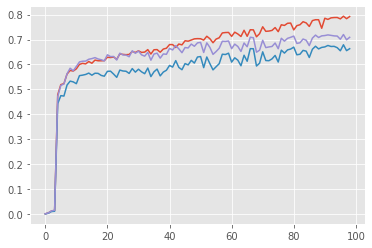

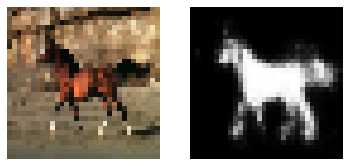

In [ ]:
fig, ax = plt.subplots(1,1)
pd.Series(train_iou).plot(ax=ax)
pd.Series(val_iou).plot(ax=ax)
pd.Series(test_iou).plot(ax=ax)
fig.canvas.draw()

draw(xdata[0], ydata_pred[0])

In [ ]:
model.load_weights("best_model")
ypred = model.predict(tf.reshape(xtest, (-1, image_size, image_size, 3 )));

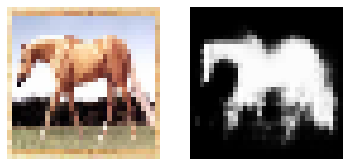

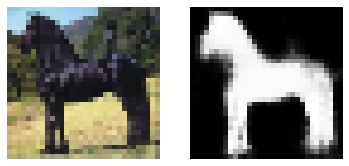

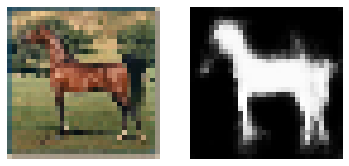

In [ ]:
draw(xtest[10], ypred[10])
draw(xtest[25], ypred[25])
draw(xtest[20], ypred[20])

In [ ]:
#IOU

iou(ytest, ypred)

0.7200430199134298

# Optimizer := Adadelta

Testing with Adadelta for 100 Epoch with Learning rate as := 0.01

In [ ]:
from keras.backend import concatenate
class NeuralNet(tf.keras.Model):
    
    def construct_CNN(self):
        # COMPLETE ME
        activation="relu"
        dropout=0.1
       
    
   
        input_shape=(image_size, image_size, 3)
        inputs= tf.keras.Input(input_shape)       

        #(ENCODER)
        c1 = Conv2D(32, 3 , activation=activation, padding='same') (inputs)
        c1 = BatchNormalization()(c1)
        c1 = Conv2D(32, 3 , activation=activation, padding='same') (c1)
        c1 = BatchNormalization()(c1)    
        p1 = MaxPooling2D((2, 2)) (c1)
       


        c2 = Conv2D(64, 3, activation=activation, padding='same') (p1)
        c2 = BatchNormalization()(c2)
        c2 = Conv2D(64, 3, activation=activation, padding='same') (c2)
        c2 = BatchNormalization()(c2)
        p2 = MaxPooling2D((2, 2)) (c2)
   


        c3 = Conv2D(128, 3, activation=activation, padding='same') (p2)
        c3 = BatchNormalization()(c3)
        c3 = Conv2D(128, 3, activation=activation, padding='same') (c3)
        c3 = BatchNormalization()(c3)
        p3 = MaxPooling2D((2, 2)) (c3)



        c4 = Conv2D(256, 3, activation=activation,  padding='same') (p3)
        c4 = BatchNormalization()(c4)
        c4 = Conv2D(256, 3, activation=activation,  padding='same') (c4)
        c4 = BatchNormalization()(c4)       
        p4 = MaxPooling2D(pool_size=(2, 2)) (c4)


        c5 = Conv2D(512, 3, activation=activation, padding='same') (p4)
        c5 = BatchNormalization()(c5)
        c5 = Conv2D(512, 3, activation=activation, padding='same') (c5)
        c5 = BatchNormalization()(c5)
        



        #(DECODER)
        
        u6 = Conv2DTranspose(256, 3, strides=2, padding='same') (c5)
        u6 = concatenate([u6, c4])
        c6 = Conv2D(256, 3, activation=activation,  padding='same') (u6)
        c6 = BatchNormalization()(c6)
        c6 = Conv2D(256, 3, activation=activation,  padding='same') (c6)
        c6 = BatchNormalization()(c6)
        
        
        u7 = Conv2DTranspose(128, 3, strides=2, padding='same') (c6)
        u7 = concatenate([u7, c3])
        c7 = Conv2D(128, 3, activation=activation, padding='same') (u7)
        c7 = BatchNormalization()(c7)
        c7 = Conv2D(128, 3, activation=activation, padding='same') (c7)
        c7 = BatchNormalization()(c7)
       
        
               
        u8 = Conv2DTranspose(64, 3, strides=2, padding='same') (c7)
        u8 = concatenate([u8, c2])
        c8 = Conv2D(64, 3, activation=activation, padding='same') (u8)
        c8 = BatchNormalization()(c8)
        c8 = Conv2D(64, 3, activation=activation, padding='same') (c8)
        c8 = BatchNormalization()(c8)
     


        u9 = Conv2DTranspose(32, 3, strides=2, padding='same') (c8)
        u9 = concatenate([u9, c1],axis=3)
        c9 = Conv2D(32, 3, activation=activation,padding='same') (u9)
        c9 = BatchNormalization()(c9)
        c9 = Conv2D(32, 3, activation=activation,padding='same') (c9)
        c9 = BatchNormalization()(c9)
        
      
        output = Conv2D(1, 1, padding='same') (c9)
        output = Flatten () (output)

        model = tf.keras.Model(inputs, output)
        
        self.model = model


    
    def construct_MLP(self):
         self.model = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(image_size, image_size, 3), dtype='float32'),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(500, activation='relu'),
                tf.keras.layers.Dropout(.2, input_shape=(500,)),
                tf.keras.layers.Dense(20, activation='relu'),
                tf.keras.layers.Dense(image_size*image_size)
            ]
        )
    
    
    def __init__(self, network_type ):
        super(NeuralNet, self).__init__()

        self.optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.001, rho=0.95, epsilon=1e-07)

        
        
        if network_type == 'MLP':
            self.construct_MLP();
        else:
            self.construct_CNN();
        

    def forward(self, x, predict=True):
        if predict:
            return tf.nn.sigmoid(self.model(x))
        return self.model(x)
  
    def get_loss(self, x, yt):
        x = tf.reshape(x, (-1, image_size, image_size, 3))
        yt = tf.reshape(yt, (-1, image_size * image_size))
        ylogits = self.forward(x, predict=False);

        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=ylogits, labels=yt);
        
        
        return tf.reduce_sum(cross_ent)
  
   
    def train_step(self, xbatch,ybatch):
 
        with tf.GradientTape() as tape:
            loss = self.get_loss(xbatch, ybatch)
        
        gradients = tape.gradient(loss, model.trainable_variables)
        
        self.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return tf.reduce_sum(loss)

    def predict(self, x):
        y = self.forward(x, predict=True)
        return y.numpy() #tf.reshape(y, (-1, image_size, image_size)).numpy()


In [ ]:
model = NeuralNet('CNN')
#model = NeuralNet('MLP')
train_iou = []
val_iou = []
test_iou = []
epoch = 1;
best_val_iou = -1;
best_test_iou = -1

In [ ]:
#Adopt similar training loop for other problems

max_epoch = 100

while epoch < max_epoch:
    loss = 0.0
    for batch in train_dataset:
        xbatch = batch[:,:image_size*image_size*3]
        ybatch = batch[:,image_size*image_size*3:]
        xbatch = tf.cast(xbatch, tf.float32);
        ybatch = tf.cast(ybatch, tf.float32);
        loss += model.train_step(xbatch, ybatch);
  
    ydata_pred = model.predict(tf.reshape(xdata, (-1, image_size, image_size, 3 )));
    yval_pred = model.predict(tf.reshape(xval, (-1, image_size, image_size, 3 )));
    ytest_pred = model.predict(tf.reshape(xtest, (-1, image_size, image_size, 3 )));
    
    train_iou.append(iou(ydata,ydata_pred))
    val_iou.append(iou(yval,yval_pred))
    test_iou.append(iou(ytest,ytest_pred))

    if val_iou[-1] > best_val_iou:
        best_test_iou = test_iou[-1]
        best_val_iou = val_iou[-1]
        model.save_weights("best_model");
    
  
    print("Epoch {}, Loss: {:0.3}, IOU - Train: {:0.3} Valid: {:0.3} Test: {:0.3}".format( epoch, loss.numpy(), train_iou[-1], val_iou[-1], best_test_iou))
  

 
    epoch += 1


Epoch 1, Loss: 6.84e+05, IOU - Train: 0.195 Valid: 0.207 Test: 0.226
Epoch 2, Loss: 6.55e+05, IOU - Train: 0.19 Valid: 0.201 Test: 0.226
Epoch 3, Loss: 6.31e+05, IOU - Train: 0.188 Valid: 0.198 Test: 0.226
Epoch 4, Loss: 6.08e+05, IOU - Train: 0.189 Valid: 0.198 Test: 0.226
Epoch 5, Loss: 5.86e+05, IOU - Train: 0.191 Valid: 0.199 Test: 0.226
Epoch 6, Loss: 5.64e+05, IOU - Train: 0.194 Valid: 0.201 Test: 0.226
Epoch 7, Loss: 5.42e+05, IOU - Train: 0.198 Valid: 0.203 Test: 0.226
Epoch 8, Loss: 5.19e+05, IOU - Train: 0.208 Valid: 0.21 Test: 0.239
Epoch 9, Loss: 4.79e+05, IOU - Train: 0.252 Valid: 0.248 Test: 0.278
Epoch 10, Loss: 3.39e+05, IOU - Train: 0.377 Valid: 0.36 Test: 0.391
Epoch 11, Loss: 2.64e+05, IOU - Train: 0.425 Valid: 0.41 Test: 0.436
Epoch 12, Loss: 2.25e+05, IOU - Train: 0.436 Valid: 0.413 Test: 0.443
Epoch 13, Loss: 2.07e+05, IOU - Train: 0.453 Valid: 0.431 Test: 0.457
Epoch 14, Loss: 1.96e+05, IOU - Train: 0.441 Valid: 0.411 Test: 0.457
Epoch 15, Loss: 1.85e+05, IOU - T

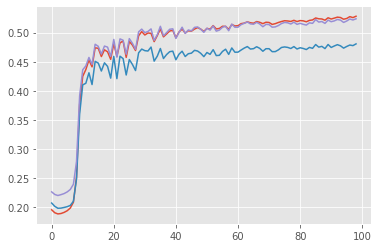

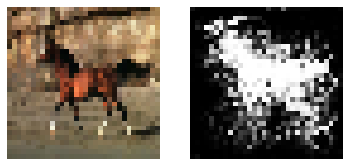

In [ ]:
fig, ax = plt.subplots(1,1)
pd.Series(train_iou).plot(ax=ax)
pd.Series(val_iou).plot(ax=ax)
pd.Series(test_iou).plot(ax=ax)
fig.canvas.draw()

draw(xdata[0], ydata_pred[0])

In [ ]:
model.load_weights("best_model")
ypred = model.predict(tf.reshape(xtest, (-1, image_size, image_size, 3 )));

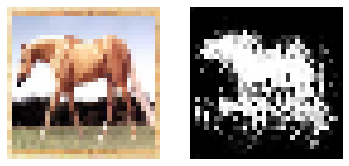

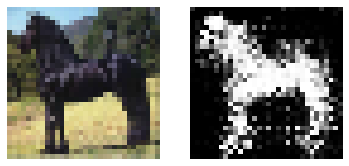

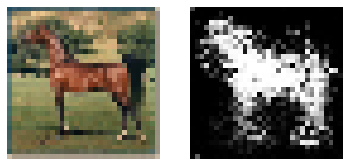

In [ ]:
draw(xtest[10], ypred[10])
draw(xtest[25], ypred[25])
draw(xtest[20], ypred[20])

In [ ]:
#IOU

iou(ytest, ypred)

0.5237069707087039

# Optimizer := Adamax

Testing with Adamax for 100 Epoch with Learning rate as := 0.01

In [ ]:
from keras.backend import concatenate
class NeuralNet(tf.keras.Model):
    
    def construct_CNN(self):
        # COMPLETE ME
        activation="relu"
        dropout=0.1
       
    
   
        input_shape=(image_size, image_size, 3)
        inputs= tf.keras.Input(input_shape)       

        #(ENCODER)
        c1 = Conv2D(32, 3 , activation=activation, padding='same') (inputs)
        c1 = BatchNormalization()(c1)
        c1 = Conv2D(32, 3 , activation=activation, padding='same') (c1)
        c1 = BatchNormalization()(c1)    
        p1 = MaxPooling2D((2, 2)) (c1)
       


        c2 = Conv2D(64, 3, activation=activation, padding='same') (p1)
        c2 = BatchNormalization()(c2)
        c2 = Conv2D(64, 3, activation=activation, padding='same') (c2)
        c2 = BatchNormalization()(c2)
        p2 = MaxPooling2D((2, 2)) (c2)
   


        c3 = Conv2D(128, 3, activation=activation, padding='same') (p2)
        c3 = BatchNormalization()(c3)
        c3 = Conv2D(128, 3, activation=activation, padding='same') (c3)
        c3 = BatchNormalization()(c3)
        p3 = MaxPooling2D((2, 2)) (c3)



        c4 = Conv2D(256, 3, activation=activation,  padding='same') (p3)
        c4 = BatchNormalization()(c4)
        c4 = Conv2D(256, 3, activation=activation,  padding='same') (c4)
        c4 = BatchNormalization()(c4)       
        p4 = MaxPooling2D(pool_size=(2, 2)) (c4)


        c5 = Conv2D(512, 3, activation=activation, padding='same') (p4)
        c5 = BatchNormalization()(c5)
        c5 = Conv2D(512, 3, activation=activation, padding='same') (c5)
        c5 = BatchNormalization()(c5)
        



        #(DECODER)
        
        u6 = Conv2DTranspose(256, 3, strides=2, padding='same') (c5)
        u6 = concatenate([u6, c4])
        c6 = Conv2D(256, 3, activation=activation,  padding='same') (u6)
        c6 = BatchNormalization()(c6)
        c6 = Conv2D(256, 3, activation=activation,  padding='same') (c6)
        c6 = BatchNormalization()(c6)
        
        
        u7 = Conv2DTranspose(128, 3, strides=2, padding='same') (c6)
        u7 = concatenate([u7, c3])
        c7 = Conv2D(128, 3, activation=activation, padding='same') (u7)
        c7 = BatchNormalization()(c7)
        c7 = Conv2D(128, 3, activation=activation, padding='same') (c7)
        c7 = BatchNormalization()(c7)
       
        
               
        u8 = Conv2DTranspose(64, 3, strides=2, padding='same') (c7)
        u8 = concatenate([u8, c2])
        c8 = Conv2D(64, 3, activation=activation, padding='same') (u8)
        c8 = BatchNormalization()(c8)
        c8 = Conv2D(64, 3, activation=activation, padding='same') (c8)
        c8 = BatchNormalization()(c8)
     


        u9 = Conv2DTranspose(32, 3, strides=2, padding='same') (c8)
        u9 = concatenate([u9, c1],axis=3)
        c9 = Conv2D(32, 3, activation=activation,padding='same') (u9)
        c9 = BatchNormalization()(c9)
        c9 = Conv2D(32, 3, activation=activation,padding='same') (c9)
        c9 = BatchNormalization()(c9)
        
      
        output = Conv2D(1, 1, padding='same') (c9)
        output = Flatten () (output)

        model = tf.keras.Model(inputs, output)
        
        self.model = model


    
    def construct_MLP(self):
         self.model = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(image_size, image_size, 3), dtype='float32'),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(500, activation='relu'),
                tf.keras.layers.Dropout(.2, input_shape=(500,)),
                tf.keras.layers.Dense(20, activation='relu'),
                tf.keras.layers.Dense(image_size*image_size)
            ]
        )
    
    
    def __init__(self, network_type ):
        super(NeuralNet, self).__init__()

        self.optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

        
        
        if network_type == 'MLP':
            self.construct_MLP();
        else:
            self.construct_CNN();
        

    def forward(self, x, predict=True):
        if predict:
            return tf.nn.sigmoid(self.model(x))
        return self.model(x)
  
    def get_loss(self, x, yt):
        x = tf.reshape(x, (-1, image_size, image_size, 3))
        yt = tf.reshape(yt, (-1, image_size * image_size))
        ylogits = self.forward(x, predict=False);

        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=ylogits, labels=yt);
        
        
        return tf.reduce_sum(cross_ent)
  
   
    def train_step(self, xbatch,ybatch):
 
        with tf.GradientTape() as tape:
            loss = self.get_loss(xbatch, ybatch)
        
        gradients = tape.gradient(loss, model.trainable_variables)
        
        self.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return tf.reduce_sum(loss)

    def predict(self, x):
        y = self.forward(x, predict=True)
        return y.numpy() #tf.reshape(y, (-1, image_size, image_size)).numpy()


In [ ]:
model = NeuralNet('CNN')
#model = NeuralNet('MLP')
train_iou = []
val_iou = []
test_iou = []
epoch = 1;
best_val_iou = -1;
best_test_iou = -1

In [ ]:
#Adopt similar training loop for other problems

max_epoch = 100

while epoch < max_epoch:
    loss = 0.0
    for batch in train_dataset:
        xbatch = batch[:,:image_size*image_size*3]
        ybatch = batch[:,image_size*image_size*3:]
        xbatch = tf.cast(xbatch, tf.float32);
        ybatch = tf.cast(ybatch, tf.float32);
        loss += model.train_step(xbatch, ybatch);
  
    ydata_pred = model.predict(tf.reshape(xdata, (-1, image_size, image_size, 3 )));
    yval_pred = model.predict(tf.reshape(xval, (-1, image_size, image_size, 3 )));
    ytest_pred = model.predict(tf.reshape(xtest, (-1, image_size, image_size, 3 )));
    
    train_iou.append(iou(ydata,ydata_pred))
    val_iou.append(iou(yval,yval_pred))
    test_iou.append(iou(ytest,ytest_pred))

    if val_iou[-1] > best_val_iou:
        best_test_iou = test_iou[-1]
        best_val_iou = val_iou[-1]
        model.save_weights("best_model");
    
  
    print("Epoch {}, Loss: {:0.3}, IOU - Train: {:0.3} Valid: {:0.3} Test: {:0.3}".format( epoch, loss.numpy(), train_iou[-1], val_iou[-1], best_test_iou))
  

 
    epoch += 1


Epoch 1, Loss: 1.82e+05, IOU - Train: 0.498 Valid: 0.45 Test: 0.503
Epoch 2, Loss: 8.01e+04, IOU - Train: 0.586 Valid: 0.535 Test: 0.592
Epoch 3, Loss: 7.06e+04, IOU - Train: 0.577 Valid: 0.5 Test: 0.592
Epoch 4, Loss: 6.42e+04, IOU - Train: 0.631 Valid: 0.578 Test: 0.639
Epoch 5, Loss: 6.04e+04, IOU - Train: 0.64 Valid: 0.594 Test: 0.652
Epoch 6, Loss: 5.96e+04, IOU - Train: 0.644 Valid: 0.582 Test: 0.652
Epoch 7, Loss: 5.49e+04, IOU - Train: 0.667 Valid: 0.618 Test: 0.668
Epoch 8, Loss: 5.23e+04, IOU - Train: 0.669 Valid: 0.6 Test: 0.668
Epoch 9, Loss: 4.9e+04, IOU - Train: 0.693 Valid: 0.627 Test: 0.684
Epoch 10, Loss: 4.8e+04, IOU - Train: 0.694 Valid: 0.619 Test: 0.684
Epoch 11, Loss: 4.71e+04, IOU - Train: 0.706 Valid: 0.646 Test: 0.696
Epoch 12, Loss: 4.52e+04, IOU - Train: 0.715 Valid: 0.666 Test: 0.708
Epoch 13, Loss: 4.44e+04, IOU - Train: 0.727 Valid: 0.651 Test: 0.708
Epoch 14, Loss: 4.55e+04, IOU - Train: 0.722 Valid: 0.677 Test: 0.718
Epoch 15, Loss: 4.16e+04, IOU - Train

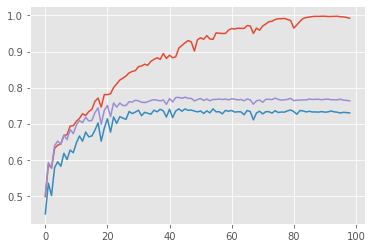

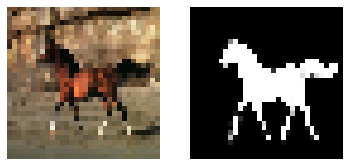

In [ ]:
fig, ax = plt.subplots(1,1)
pd.Series(train_iou).plot(ax=ax)
pd.Series(val_iou).plot(ax=ax)
pd.Series(test_iou).plot(ax=ax)
fig.canvas.draw()

draw(xdata[0], ydata_pred[0])

In [ ]:
model.load_weights("best_model")
ypred = model.predict(tf.reshape(xtest, (-1, image_size, image_size, 3 )));

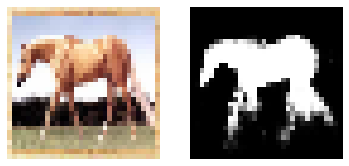

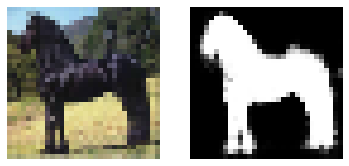

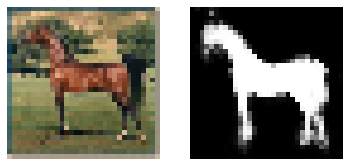

In [ ]:
draw(xtest[10], ypred[10])
draw(xtest[25], ypred[25])
draw(xtest[20], ypred[20])

In [ ]:
#IOU

iou(ytest, ypred)

0.7728205776406226

# Optimizer := RMSprop

Testing with RMSprop for 100 Epoch with Learning rate as := 0.001

In [ ]:
from keras.backend import concatenate
class NeuralNet(tf.keras.Model):
    
    def construct_CNN(self):
        # COMPLETE ME
        activation="relu"
        dropout=0.1
       
    
   
        input_shape=(image_size, image_size, 3)
        inputs= tf.keras.Input(input_shape)       

        #(ENCODER)
        c1 = Conv2D(32, 3 , activation=activation, padding='same') (inputs)
        c1 = BatchNormalization()(c1)
        c1 = Conv2D(32, 3 , activation=activation, padding='same') (c1)
        c1 = BatchNormalization()(c1)    
        p1 = MaxPooling2D((2, 2)) (c1)
       


        c2 = Conv2D(64, 3, activation=activation, padding='same') (p1)
        c2 = BatchNormalization()(c2)
        c2 = Conv2D(64, 3, activation=activation, padding='same') (c2)
        c2 = BatchNormalization()(c2)
        p2 = MaxPooling2D((2, 2)) (c2)
   


        c3 = Conv2D(128, 3, activation=activation, padding='same') (p2)
        c3 = BatchNormalization()(c3)
        c3 = Conv2D(128, 3, activation=activation, padding='same') (c3)
        c3 = BatchNormalization()(c3)
        p3 = MaxPooling2D((2, 2)) (c3)



        c4 = Conv2D(256, 3, activation=activation,  padding='same') (p3)
        c4 = BatchNormalization()(c4)
        c4 = Conv2D(256, 3, activation=activation,  padding='same') (c4)
        c4 = BatchNormalization()(c4)       
        p4 = MaxPooling2D(pool_size=(2, 2)) (c4)


        c5 = Conv2D(512, 3, activation=activation, padding='same') (p4)
        c5 = BatchNormalization()(c5)
        c5 = Conv2D(512, 3, activation=activation, padding='same') (c5)
        c5 = BatchNormalization()(c5)
        



        #(DECODER)
        
        u6 = Conv2DTranspose(256, 3, strides=2, padding='same') (c5)
        u6 = concatenate([u6, c4])
        c6 = Conv2D(256, 3, activation=activation,  padding='same') (u6)
        c6 = BatchNormalization()(c6)
        c6 = Conv2D(256, 3, activation=activation,  padding='same') (c6)
        c6 = BatchNormalization()(c6)
        
        
        u7 = Conv2DTranspose(128, 3, strides=2, padding='same') (c6)
        u7 = concatenate([u7, c3])
        c7 = Conv2D(128, 3, activation=activation, padding='same') (u7)
        c7 = BatchNormalization()(c7)
        c7 = Conv2D(128, 3, activation=activation, padding='same') (c7)
        c7 = BatchNormalization()(c7)
       
        
               
        u8 = Conv2DTranspose(64, 3, strides=2, padding='same') (c7)
        u8 = concatenate([u8, c2])
        c8 = Conv2D(64, 3, activation=activation, padding='same') (u8)
        c8 = BatchNormalization()(c8)
        c8 = Conv2D(64, 3, activation=activation, padding='same') (c8)
        c8 = BatchNormalization()(c8)
     


        u9 = Conv2DTranspose(32, 3, strides=2, padding='same') (c8)
        u9 = concatenate([u9, c1],axis=3)
        c9 = Conv2D(32, 3, activation=activation,padding='same') (u9)
        c9 = BatchNormalization()(c9)
        c9 = Conv2D(32, 3, activation=activation,padding='same') (c9)
        c9 = BatchNormalization()(c9)
        
      
        output = Conv2D(1, 1, padding='same') (c9)
        output = Flatten () (output)

        model = tf.keras.Model(inputs, output)
        
        self.model = model


    
    def construct_MLP(self):
         self.model = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(image_size, image_size, 3), dtype='float32'),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(500, activation='relu'),
                tf.keras.layers.Dropout(.2, input_shape=(500,)),
                tf.keras.layers.Dense(20, activation='relu'),
                tf.keras.layers.Dense(image_size*image_size)
            ]
        )
    
    
    def __init__(self, network_type ):
        super(NeuralNet, self).__init__()

        self.optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07)
        
        
        if network_type == 'MLP':
            self.construct_MLP();
        else:
            self.construct_CNN();
        

    def forward(self, x, predict=True):
        if predict:
            return tf.nn.sigmoid(self.model(x))
        return self.model(x)
  
    def get_loss(self, x, yt):
        x = tf.reshape(x, (-1, image_size, image_size, 3))
        yt = tf.reshape(yt, (-1, image_size * image_size))
        ylogits = self.forward(x, predict=False);

        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=ylogits, labels=yt);
        
        
        return tf.reduce_sum(cross_ent)
  
   
    def train_step(self, xbatch,ybatch):
 
        with tf.GradientTape() as tape:
            loss = self.get_loss(xbatch, ybatch)
        
        gradients = tape.gradient(loss, model.trainable_variables)
        
        self.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return tf.reduce_sum(loss)

    def predict(self, x):
        y = self.forward(x, predict=True)
        return y.numpy() #tf.reshape(y, (-1, image_size, image_size)).numpy()


In [ ]:
model = NeuralNet('CNN')
#model = NeuralNet('MLP')
train_iou = []
val_iou = []
test_iou = []
epoch = 1;
best_val_iou = -1;
best_test_iou = -1

In [ ]:
#Adopt similar training loop for other problems

max_epoch = 100

while epoch < max_epoch:
    loss = 0.0
    for batch in train_dataset:
        xbatch = batch[:,:image_size*image_size*3]
        ybatch = batch[:,image_size*image_size*3:]
        xbatch = tf.cast(xbatch, tf.float32);
        ybatch = tf.cast(ybatch, tf.float32);
        loss += model.train_step(xbatch, ybatch);
  
    ydata_pred = model.predict(tf.reshape(xdata, (-1, image_size, image_size, 3 )));
    yval_pred = model.predict(tf.reshape(xval, (-1, image_size, image_size, 3 )));
    ytest_pred = model.predict(tf.reshape(xtest, (-1, image_size, image_size, 3 )));
    
    train_iou.append(iou(ydata,ydata_pred))
    val_iou.append(iou(yval,yval_pred))
    test_iou.append(iou(ytest,ytest_pred))

    if val_iou[-1] > best_val_iou:
        best_test_iou = test_iou[-1]
        best_val_iou = val_iou[-1]
        model.save_weights("best_model");
    
  
    print("Epoch {}, Loss: {:0.3}, IOU - Train: {:0.3} Valid: {:0.3} Test: {:0.3}".format( epoch, loss.numpy(), train_iou[-1], val_iou[-1], best_test_iou))
  

 
    epoch += 1


Epoch 1, Loss: 5.1e+05, IOU - Train: 0.346 Valid: 0.297 Test: 0.359
Epoch 2, Loss: 9.85e+04, IOU - Train: 0.488 Valid: 0.424 Test: 0.507
Epoch 3, Loss: 8.55e+04, IOU - Train: 0.58 Valid: 0.51 Test: 0.582
Epoch 4, Loss: 8.75e+04, IOU - Train: 0.616 Valid: 0.562 Test: 0.627
Epoch 5, Loss: 7.55e+04, IOU - Train: 0.59 Valid: 0.521 Test: 0.627
Epoch 6, Loss: 6.34e+04, IOU - Train: 0.644 Valid: 0.586 Test: 0.652
Epoch 7, Loss: 6.54e+04, IOU - Train: 0.642 Valid: 0.565 Test: 0.652
Epoch 8, Loss: 5.87e+04, IOU - Train: 0.551 Valid: 0.533 Test: 0.652
Epoch 9, Loss: 5.38e+04, IOU - Train: 0.677 Valid: 0.593 Test: 0.668
Epoch 10, Loss: 5.22e+04, IOU - Train: 0.696 Valid: 0.61 Test: 0.671
Epoch 11, Loss: 4.33e+04, IOU - Train: 0.744 Valid: 0.671 Test: 0.728
Epoch 12, Loss: 4.34e+04, IOU - Train: 0.737 Valid: 0.648 Test: 0.728
Epoch 13, Loss: 4.38e+04, IOU - Train: 0.731 Valid: 0.629 Test: 0.728
Epoch 14, Loss: 4.53e+04, IOU - Train: 0.733 Valid: 0.641 Test: 0.728
Epoch 15, Loss: 3.26e+04, IOU - Tr

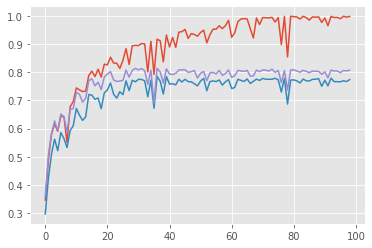

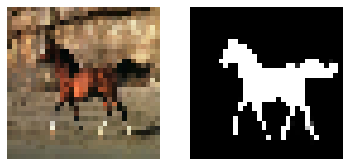

In [ ]:
fig, ax = plt.subplots(1,1)
pd.Series(train_iou).plot(ax=ax)
pd.Series(val_iou).plot(ax=ax)
pd.Series(test_iou).plot(ax=ax)
fig.canvas.draw()

draw(xdata[0], ydata_pred[0])

In [ ]:
model.load_weights("best_model")
ypred = model.predict(tf.reshape(xtest, (-1, image_size, image_size, 3 )));

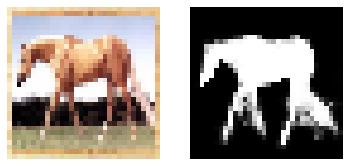

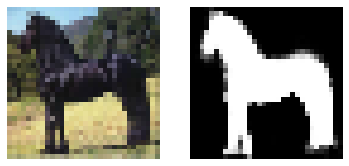

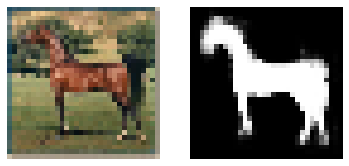

In [ ]:
draw(xtest[10], ypred[10])
draw(xtest[25], ypred[25])
draw(xtest[20], ypred[20])

In [ ]:
#IOU

iou(ytest, ypred)

0.8139378503341943